In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data
from PIL import Image
import scipy.misc
import glob
import numpy as np
import matplotlib.pyplot as plt

# Gram Matrix

In [2]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)

# Style transfer network

In [3]:
class StyleTransferNetwork(object):
    def __init__(self, content,  multi_styles):
        super(StyleTransferNetwork, self).__init__()
        self.num_of_convs_for_style = 5    # change this to account for the number of convolution layers used for style
        self.num_styles = len(multi_styles) # the number of styles we want to transfer to content
        self.mult_style_weight = [0] * self.num_styles  # weights according to average weighting of style loss
        self.styles = multi_styles
        self.log = 0 # for logging the loss which will be used to plot log-loss
        self.content = content

        self.pastiche = Variable((torch.randn(content.size())).type_as(content.data), requires_grad=True) # use for
        # random initialization

        self.content_layers = ['conv_3_1']
        self.style_layers = []
        self.style_layers = ['conv_1_1', 'conv_1_2', 'conv_2_1', 'conv_2_2', 'conv_3_1'] # if you want to manually

        # change the layers used for style loss uncomment last line and comment out the for loop in next line
        # for i in range(0, self.num_of_convs_for_style):
        #      self.style_layers.append("conv_" + str(i+1) + "_1")


        # this line if random initialization is used
        self.style_loss_weight = [1] * self.num_of_convs_for_style
        # self.style_loss_weight = [n / (self.num_of_convs_for_style) for n in [64, 64, 128, 128, 256]]


        self.content_weight = 1     # this is alpha according to the paper
        self.style_weight = 1000    # this is beta according to paper

        self.loss_network = models.vgg19(pretrained=True)
        for param in self.loss_network.parameters():
            param.requires_grad = False
        self.gram = GramMatrix()
        self.loss = nn.MSELoss()
        self.optimizer = optim.Adamax([self.pastiche])

        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.loss_network.cuda()
            self.gram.cuda()

    def train(self):
        def closure():
            self.optimizer.zero_grad()

            pastiche = self.pastiche

            # the following two lines are used for clamping the pastiche to be between 0 and 1, uncomment when pastiche
            # is initialized to random noise
            pastiche.data[pastiche.data > 1] = 1
            pastiche.data[pastiche.data < 0] = 0


            content = self.content.clone()
            styles_to_transfer = []
            for z in range(0, self.num_styles):
                styles_to_transfer.append(self.styles[z].clone())
            styles_loss = torch.zeros(self.num_styles).type(dtype)
            content_loss = 0
            j = 0
            i = 1
            layer_count = 1
            not_inplace = lambda layer: nn.ReLU(inplace=False) if isinstance(layer, nn.ReLU) else layer
            for layer in list(self.loss_network.features):
                layer = not_inplace(layer)
                if self.use_cuda:
                    layer.cuda()

                pastiche, content = layer.forward(pastiche), layer.forward(content)

                for z in range(0, self.num_styles):
                    styles_to_transfer[z] = layer.forward(styles_to_transfer[z])

                if isinstance(layer, nn.Conv2d):
                    name = "conv_" + str(layer_count) + "_" + str(i)
                    if name in self.content_layers:
                        content_loss += self.loss(pastiche, content.detach())

                    if name in self.style_layers:
                        pastiche_g = self.gram.forward(pastiche)
                        for z in range(0, self.num_styles):
                            style_g = self.gram.forward(styles_to_transfer[z])
                            styles_loss[z] += self.style_loss_weight[j] * self.loss(self.style_weight *pastiche_g,
                                                                                    self.style_weight *style_g.detach())
                        j += 1
                if isinstance(layer, nn.ReLU):
                    i += 1
                if isinstance(layer, nn.MaxPool2d):
                    layer_count += 1
                    i = 1
            tot_style_loss = sum(styles_loss)
            total_loss = self.content_weight * content_loss
            for z in range(0, self.num_styles):

                #self.mult_style_weight[z] = 1.0 / self.num_styles  # uncomment this line and comment out next
                # if custom (equal in this case) weight is needed for each style

                self.mult_style_weight[z] = styles_loss[z]/tot_style_loss # comment out if custom weights for each style
                # is needed
                total_loss +=  self.mult_style_weight[z] * styles_loss[z]
            total_loss.backward()
            self.log = total_loss
            return total_loss

        self.optimizer.step(closure)
        return self.pastiche

# Input image preprocessing

In [4]:
imsize = 256

pre_process = transforms.Compose([transforms.Resize((imsize, imsize)),
                                  transforms.ToTensor(),
                                  ])


# Output Image Post-processing

In [5]:
post_process_a = transforms.Compose([])


post_process_b = transforms.Compose([transforms.ToPILImage()])

# helper functions

In [6]:
def postp(tensor):
    t = post_process_a(tensor)
    t[t > 1] = 1 # to clamp results in the range [0,1]
    t[t < 0] = 0 # to clamp results in the range [0,1]
    img = post_process_b(t)
    return img


def load_styles(path):
    styles = []
    for file in glob.glob(path+"/*.jpg"):
        styles.append(image_loader(file).type(dtype))

    return styles


def image_loader(image_name):
    image = Image.open(image_name)
    image = pre_process(image)
    image = Variable(image.unsqueeze(0))
    return image


# CUDA Configurations

In [7]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# Main

In [8]:
def main():
    path_styles = "./styles"
    path_contents = "./contents"
    out_path = "./outputs"
    num_epochs = 20000
    styles = load_styles(path_styles)
    for cont_file in glob.glob(path_contents + "/*.jpg"):
        log = []
        content = image_loader(cont_file).type(dtype)

        style_cnn = StyleTransferNetwork(content, styles)
        out_counter = 0
        for i in range(num_epochs + 1):
            pastiche = style_cnn.train()

            log.append([i, style_cnn.log.item()])
            if i % 1000 == 0:
                print(str(style_cnn.log.item()) + " " + str(i))
                print("Iteration: %d" % i)
                cont_name = cont_file.replace('./contents\\', "")
                cont_name = cont_name.replace(".jpg", "")
                path = out_path + "/" + cont_name + "_%d.png" % out_counter
                out_img = postp(pastiche.data[0].cpu().squeeze())
                scipy.misc.imsave(path, out_img)
                out_counter += 1
        a = np.array(log)
        plt.figure(2)
        plt.plot(a[1:, 0], np.log(a[1:, 1]))
        plt.xlabel('Iteration')
        plt.ylabel('loss(log)')
        plt.show()

# Runing the code

41095.8828125 0
Iteration: 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


487.0604248046875 1000
Iteration: 1000
270.358642578125 2000
Iteration: 2000
219.71609497070312 3000
Iteration: 3000
199.4637451171875 4000
Iteration: 4000
189.59622192382812 5000
Iteration: 5000
184.3130645751953 6000
Iteration: 6000
181.52590942382812 7000
Iteration: 7000
179.90655517578125 8000
Iteration: 8000
179.12152099609375 9000
Iteration: 9000
178.87030029296875 10000
Iteration: 10000
178.78350830078125 11000
Iteration: 11000
178.740478515625 12000
Iteration: 12000
178.712890625 13000
Iteration: 13000
178.69229125976562 14000
Iteration: 14000
178.67752075195312 15000
Iteration: 15000
178.66590881347656 16000
Iteration: 16000
178.6578826904297 17000
Iteration: 17000
178.651123046875 18000
Iteration: 18000
178.64671325683594 19000
Iteration: 19000
178.64129638671875 20000
Iteration: 20000


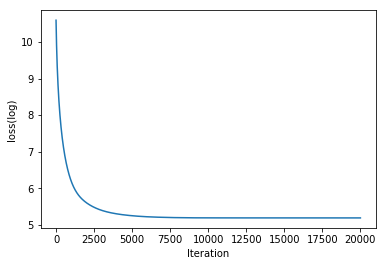

In [9]:
main()